In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json

In [16]:
with open('data/shell_comparison_RAL_Release.json') as f:
    data = json.load(f)
    df_runs = pd.json_normalize(data)
    df_runs.columns = [col.split('.')[-1] for col in df_runs.columns]

In [17]:
agged = df_runs.groupby(['scene','planner']).agg(['mean','sem'])[['total_experiment_runtime','total_path_length','n_visited']]

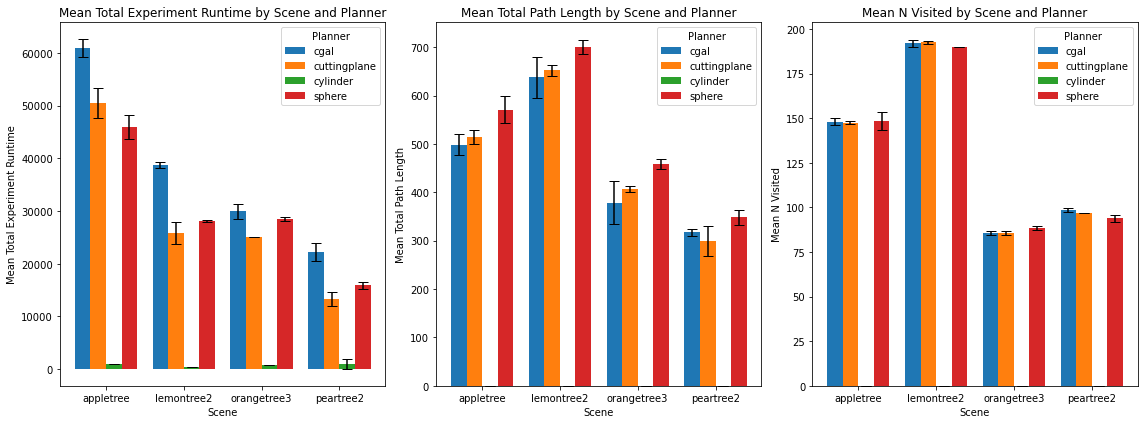

<Figure size 432x288 with 0 Axes>

In [19]:
scene_order = agged.index.get_level_values('scene').unique()
planner_order = agged.index.get_level_values('planner').unique()

bar_width = 0.2
bar_positions = {}
for i, planner in enumerate(planner_order):
    bar_positions[planner] = [j + i * bar_width for j in range(len(scene_order))]


def create_grouped_bar_chart(ax, metric):
    for planner in planner_order:
        ax.bar(bar_positions[planner], agged.loc[pd.IndexSlice[:, planner], (metric, 'mean')], 
               width=bar_width, label=planner,
               yerr=agged.loc[pd.IndexSlice[:, planner], (metric, 'sem')] * 1.96,
               capsize=5)

    ax.set_xticks([pos + bar_width * (len(planner_order) - 1) / 2 for pos in bar_positions[planner_order[0]]])
    ax.set_xticklabels(scene_order)
    ax.set_xlabel('Scene')
    ax.set_ylabel(f'Mean {metric.replace("_", " ").title()}')
    ax.set_title(f'Mean {metric.replace("_", " ").title()} by Scene and Planner')
    ax.legend(title='Planner')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))

create_grouped_bar_chart(ax1, 'total_experiment_runtime')
create_grouped_bar_chart(ax2, 'total_path_length')
create_grouped_bar_chart(ax3, 'n_visited')

plt.tight_layout()
plt.show()

plt.savefig('comparison_trees.pdf')